In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ot
from utils.image import Image
from utils.Visualizations import *
from utils.utils import *
import itertools
import glob
from scipy.stats import normaltest, gaussian_kde, probplot
from scipy.optimize import curve_fit
import time
from tqdm import tqdm

In [3]:
dotmark_pictures_path = "..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
noise_values = np.logspace(start = -8, stop = 2, num = 100)
categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = [path for path in glob.glob(categories_pattern) if os.path.isdir(path)]
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]
num_exp = 100  # Number of experiments to run for each image pair and noise level

In [4]:
results_B_x = pd.DataFrame(columns=[
    'Category', 'Image_Pair', 'Alpha_1_Mean', 'Alpha_1_Std', 'Alpha_2_Mean', 'Alpha_2_Std', 'B_x_Mean', 'B_x_Std', 'Noise', 'B_x_tilde_Mean', 'B_x_tilde_Std'])

for category in category_names:
    print(f'Category: {category}')
    for noise in noise_values:
        for pair in list(itertools.combinations(image_numbers, 2)):
            alpha_1s = np.zeros(num_exp)
            alpha_2s = np.zeros(num_exp)
            B_xs = np.zeros((num_exp, resolution, resolution))  # Store B_x for each experiment
            B_xs_tilde = np.zeros((num_exp, resolution, resolution))  # Store B_x_tilde for each experiment
            image1 = Image(resolution, category_names[0], pair[0], full_path)
            image2 = Image(resolution, category_names[0], pair[1], full_path)

            for i in range(num_exp):
                results = Image.process_images(image1, image2, noise)
                alpha_1 = (1 / image1.image_post_noised.sum()) - 1
                alpha_2 = (1 / image2.image_post_noised.sum()) - 1
                B_x = image1.image_post_noised * alpha_1 - image2.image_post_noised * alpha_2
                alpha_1s[i] = alpha_1
                alpha_2s[i] = alpha_2
                B_xs[i, :, :] = B_x  # Store each B_x result
                B_xs_tilde[i, :, :] = B_x - alpha_1 * image1.image + alpha_2 * image2.image

            # Calculate the means and standard deviations
            alpha_1_mean, alpha_1_std = alpha_1s.mean(), alpha_1s.std()
            alpha_2_mean, alpha_2_std = alpha_2s.mean(), alpha_2s.std()
            B_x_mean, B_x_std = B_xs.mean(axis=0), B_xs.std(axis=0)
            B_x_tilde_mean, B_x_tilde_std = B_xs_tilde.mean(axis=0), B_xs_tilde.std(axis=0)

            # Store results in the DataFrame
            results_B_x = results_B_x._append({
                'Category': category,
                'Noise': noise,
                'Image_Pair': pair,
                'Alpha_1_Mean': alpha_1_mean,
                'Alpha_1_Std': alpha_1_std,
                'Alpha_2_Mean': alpha_2_mean,
                'Alpha_2_Std': alpha_2_std,
                'B_x_Mean': B_x_mean.mean(),  # Storing the overall mean of the matrix
                'B_x_Std': B_x_std.mean(),  # Storing the overall mean of the std of the matrix
                'B_x_tilde_Mean': B_x_tilde_mean.mean(),
                'B_x_tilde_Std': B_x_tilde_std.mean()
            }, ignore_index=True)

Category: CauchyDensity


C:\Users\eriki\AppData\Local\Temp\ipykernel_34500\252702101.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_B_x = results_B_x._append({


Category: ClassicImages
Category: GRFmoderate
Category: GRFrough
Category: GRFsmooth
Category: LogGRF
Category: LogitGRF
Category: MicroscopyImages
Category: Shapes
Category: WhiteNoise


In [5]:
results_B_x.head()

,Category,Image_Pair,Alpha_1_Mean,Alpha_1_Std,Alpha_2_Mean,Alpha_2_Std,B_x_Mean,B_x_Std,Noise,B_x_tilde_Mean,B_x_tilde_Std
0,CauchyDensity,"(01, 02)",-0.000002,2.851938e-07,-0.000002,3.691095e-07,-8.728506e-12,5.501542e-10,1.000000e-08,1.808292e-17,2.894895e-14
1,CauchyDensity,"(01, 03)",-0.000002,2.828006e-07,-0.000002,3.267938e-07,-8.176763e-12,5.040395e-10,1.000000e-08,-1.276815e-18,2.398169e-14
2,CauchyDensity,"(01, 04)",-0.000002,2.294184e-07,-0.000002,3.648083e-07,4.954917e-11,4.716490e-10,1.000000e-08,2.440042e-16,2.394137e-14
3,CauchyDensity,"(01, 05)",-0.000002,2.615586e-07,-0.000002,3.020015e-07,-1.840401e-11,5.229586e-10,1.000000e-08,-3.707327e-17,2.299725e-14
4,CauchyDensity,"(01, 06)",-0.000002,2.724595e-07,-0.000002,3.369220e-07,2.194191e-11,5.502306e-10,1.000000e-08,1.099544e-16,2.340748e-14


In [6]:
results_B_x_new = results_B_x.drop(['Category', 'Image_Pair'], axis=1)
results_B_x_new['log_Noise'] = np.log10(results_B_x['Noise'])
grouped_results = results_B_x_new.groupby('Noise').mean().reset_index()

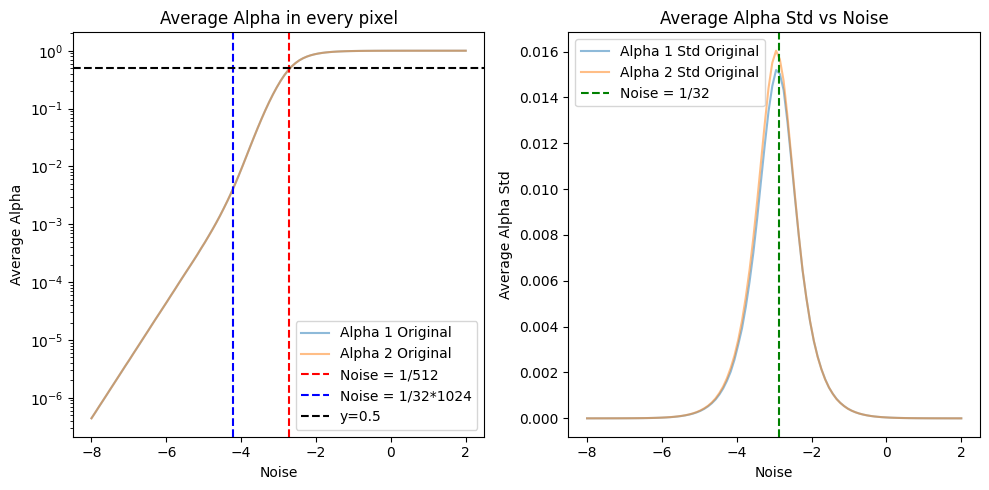

In [7]:
# Plot the alphas:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(grouped_results['log_Noise'], -grouped_results['Alpha_1_Mean'], label='Alpha 1 Original', alpha=0.5)
plt.plot(grouped_results['log_Noise'], -grouped_results['Alpha_2_Mean'], label='Alpha 2 Original', alpha=0.5)
# Draw a line where noise = 1/1024
plt.axvline(x=np.log10(1/512), color='r', linestyle='--', label='Noise = 1/512')
#plt.axvline(x=np.log10(1/16), color='g', linestyle='--', label='Noise = 1/32')
plt.axvline(x=np.log10(1/(32*512)), color='b', linestyle='--', label='Noise = 1/32*1024')
# Draw a horizontal line in y=0.5
plt.axhline(y=0.5, color='k', linestyle='--', label='y=0.5')
plt.xlabel('Noise')
plt.yscale('log')
plt.ylabel('Average Alpha')
plt.title('Average Alpha in every pixel')
plt.legend()

# Plot Alpha Std vs Noise
plt.subplot(1, 2, 2)
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_1_Std'], label='Alpha 1 Std Original', alpha=0.5)
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_2_Std'], label='Alpha 2 Std Original', alpha=0.5)
#plt.axvline(x=np.log10(1/1024), color='r', linestyle='--', label='Noise = 1/1024')
#plt.axvline(x=np.log10(1/512), color='g', linestyle='--', label='Noise = 1/32')
plt.axvline(x=np.log10(1/(512*np.sqrt(2))), color='g', linestyle='--', label='Noise = 1/32')
plt.xlabel('Noise')
# plt.yscale('log')
plt.ylabel('Average Alpha Std')
plt.title('Average Alpha Std vs Noise')
plt.legend()

plt.tight_layout()
plt.show()

# Check the Normality of alpha for specific noise values.

In [8]:
#Check the normality of alpha 1 and alpha 2
alpha_df = pd.DataFrame()
num_exp = 500

for noise in tqdm(noise_values):
    for pair in list(itertools.combinations(image_numbers, 2)):
        alpha_1s = np.zeros(num_exp)
        alpha_2s = np.zeros(num_exp)
        image1 = Image(resolution, category_names[0], pair[0], full_path)
        image2 = Image(resolution, category_names[0], pair[1], full_path)

        for i in range(num_exp):
            results = Image.process_images(image1, image2, noise)
            alpha_1 = (1 / image1.image_post_noised.sum()) - 1
            alpha_2 = (1 / image2.image_post_noised.sum()) - 1
            alpha_1s[i] = alpha_1
            alpha_2s[i] = alpha_2

        # Calculate the means and standard deviations
        alpha_1_mean, alpha_1_std = alpha_1s.mean(), alpha_1s.std()
        alpha_2_mean, alpha_2_std = alpha_2s.mean(), alpha_2s.std()

        # Store results in the DataFrame
        alpha_df = alpha_df._append({
            'Noise': noise,
            'alpha_1': alpha_1_mean,
            'alpha_2': alpha_2_mean,
            'alpha_1_std': alpha_1_std,
            'alpha_2_std': alpha_2_std,
            'alpha_1_p_value': normaltest(alpha_1s)[1],
            'alpha_2_p_value': normaltest(alpha_2s)[1]          
        }, ignore_index=True)

100%|██████████| 100/100 [03:31<00:00,  2.11s/it]


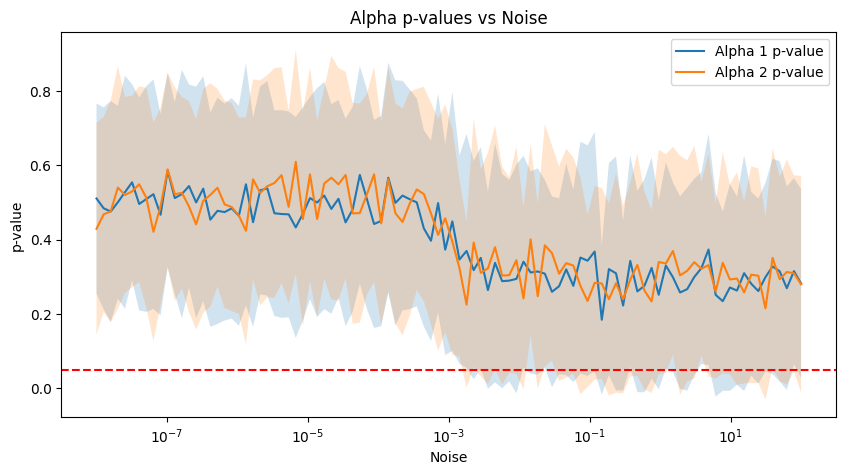

In [9]:
grouped_mean = alpha_df.groupby('Noise').mean().reset_index()
grouped_std = alpha_df.groupby('Noise').std().reset_index()

# Plot the mean p-values vs noise
plt.figure(figsize=(10, 5))
plt.plot(grouped_mean['Noise'], grouped_mean['alpha_1_p_value'], label='Alpha 1 p-value')
plt.plot(grouped_mean['Noise'], grouped_mean['alpha_2_p_value'], label='Alpha 2 p-value')

# Add shaded area for standard deviation
plt.fill_between(grouped_mean['Noise'], grouped_mean['alpha_1_p_value'] - grouped_std['alpha_1_p_value'], 
                 grouped_mean['alpha_1_p_value'] + grouped_std['alpha_1_p_value'], alpha=0.2)
plt.fill_between(grouped_mean['Noise'], grouped_mean['alpha_2_p_value'] - grouped_std['alpha_2_p_value'], 
                 grouped_mean['alpha_2_p_value'] + grouped_std['alpha_2_p_value'], alpha=0.2)

plt.axhline(y=0.05, color='r', linestyle='--')
plt.xlabel('Noise')
plt.xscale('log')
plt.ylabel('p-value')
plt.title('Alpha p-values vs Noise')
plt.legend()
plt.show()

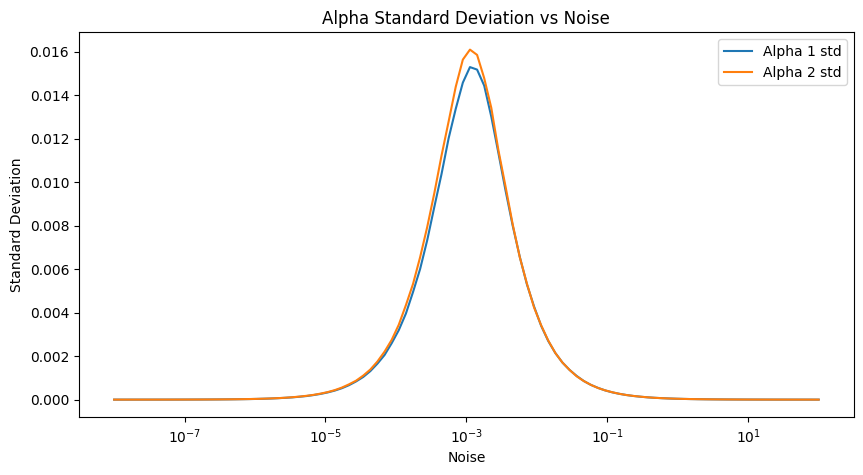

In [10]:
grouped = alpha_df.groupby('Noise').mean().reset_index()

# Plot the p-values vs noise
plt.figure(figsize=(10, 5))
plt.plot(grouped['Noise'], grouped['alpha_1_std'], label='Alpha 1 std')
plt.plot(grouped['Noise'], grouped['alpha_2_std'], label='Alpha 2 std')
plt.xlabel('Noise')
plt.xscale('log')
plt.ylabel('Standard Deviation')
plt.title('Alpha Standard Deviation vs Noise')
plt.legend()
plt.show()

## Experiment on a single pair

In [11]:
pair = list(itertools.combinations(image_numbers, 2))[0]
noise = noise_values[10]

alpha_1s = np.zeros(num_exp)
alpha_2s = np.zeros(num_exp)
image1 = Image(resolution, category_names[0], pair[0], full_path)
image2 = Image(resolution, category_names[0], pair[1], full_path)

for i in range(num_exp):
    results = Image.process_images(image1, image2, noise)
    alpha_1 = (1 / image1.image_post_noised.sum()) - 1
    alpha_2 = (1 / image2.image_post_noised.sum()) - 1
    alpha_1s[i] = alpha_1
    alpha_2s[i] = alpha_2

Alpha 1: 0.6618446083285383
Alpha 2: 0.08896006033249833


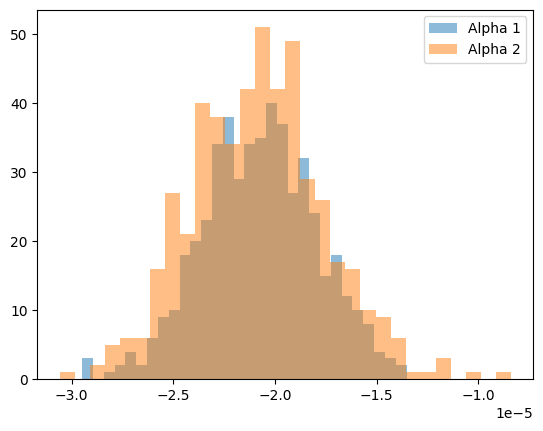

In [12]:
plt.hist(alpha_1s, bins=30, alpha=0.5, label='Alpha 1')
plt.hist(alpha_2s, bins=30, alpha=0.5, label='Alpha 2')
# Check if the data is normally distributed
print('Alpha 1:', normaltest(alpha_1s)[1])
print('Alpha 2:', normaltest(alpha_2s)[1])
plt.legend()
plt.show()

Maximum value for σ = 1/512.0: k = 0.001, value = 0.00037913946233512094
Maximum value for σ = 1/1024.0: k = 0.001, value = 7.771179159514241e-05
Maximum value for σ = 1/2048.0: k = 0.001, value = 3.6420601297882844e-06
Maximum value for σ = 1/4096.0: k = 0.001, value = 1.1350651551282386e-09


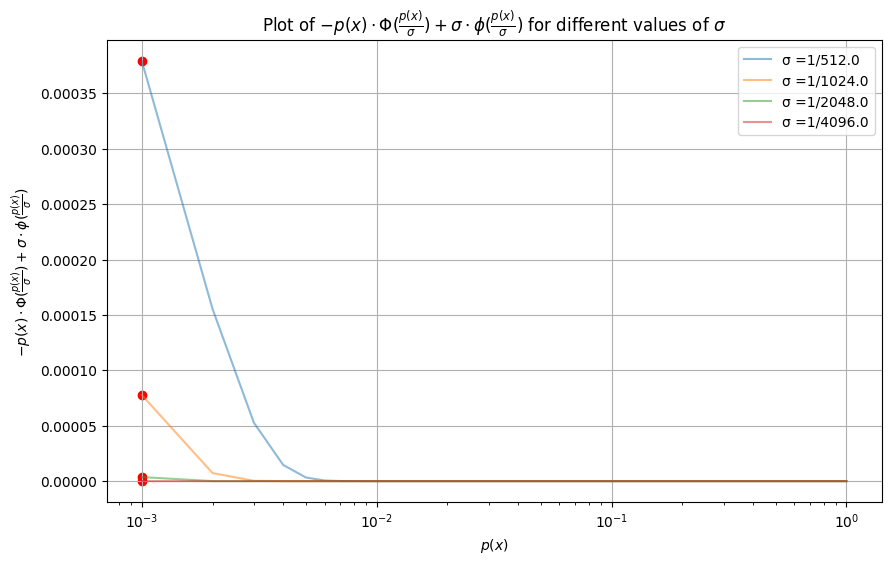

In [13]:
def k_P_eps_less_than_k(p, sigma):
    return -p * norm.cdf(-p / sigma) + sigma * norm.pdf(-p / sigma)

# Generate values of k between -1 and 0 (since k is negative)
p_x_values = np.linspace(1e-3, 1, 1000)

# Updated smaller values of σ
sigma_values = [1/512, 1/1024, 1/2048, 1/4096]
# sigma_values = np.logspace(-30, -10, 20, base=2)

# Plot the function for different values of σ to visually inspect for maximum points
plt.figure(figsize=(10, 6))
for sigma in sigma_values:
    function_values = k_P_eps_less_than_k(p_x_values, sigma)
    plt.plot(p_x_values, function_values, label=f'σ =1/{1/sigma}', alpha=0.5)
    max_index = np.argmax(function_values)
    max_k = p_x_values[max_index]
    max_value = function_values[max_index]
    print(f'Maximum value for σ = 1/{1/sigma}: k = {max_k}, value = {max_value}')
    plt.scatter(max_k, max_value, marker='o', color='red')  # Mark the maximum point

plt.title(r'Plot of $-p(x) \cdot \Phi(\frac{p(x)}{\sigma}) + \sigma \cdot \phi(\frac{p(x)}{\sigma})$ for different values of $\sigma$')
plt.xlabel(r'$p(x)$')
plt.ylabel(r'$-p(x) \cdot \Phi(\frac{p(x)}{\sigma}) + \sigma \cdot \phi(\frac{p(x)}{\sigma})$')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.show()

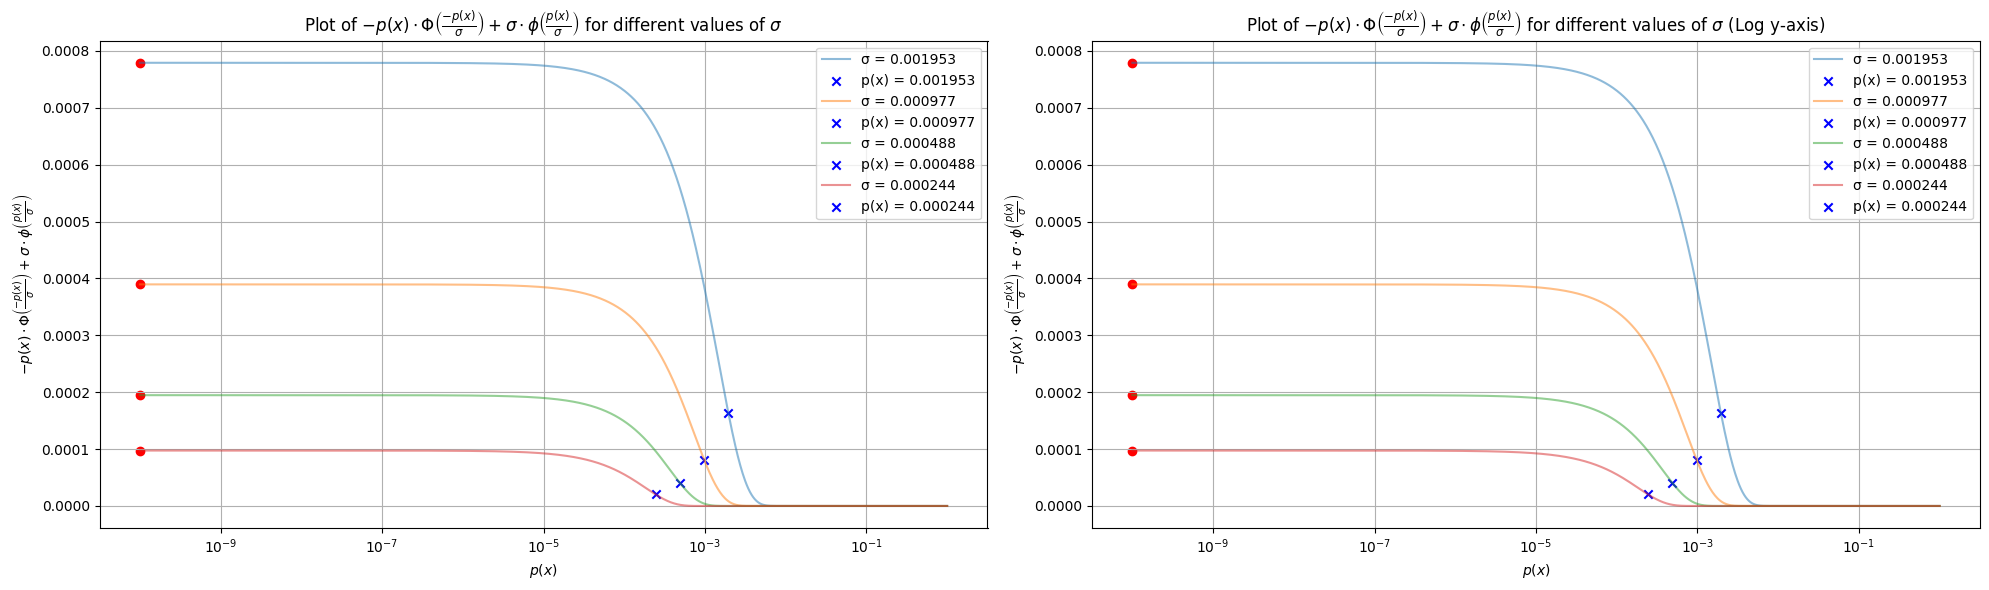

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the function with the normal CDF and PDF
def k_P_eps_less_than_k(p, sigma, threshold=1e-10):
    values = -p * norm.cdf(-p / sigma) + sigma * norm.pdf(-p / sigma)
    values[values < threshold] = 0
    return values

# Generate values of p(x) between 0 and 1
p_x_values = np.logspace(-10, 0, 1000)

# Updated smaller values of sigma
sigma_values = [1/512, 1/1024, 1/2048, 1/4096]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot settings
titles = [
    r'Plot of $-p(x) \cdot \Phi\left(\frac{-p(x)}{\sigma}\right) + \sigma \cdot \phi\left(\frac{p(x)}{\sigma}\right)$ for different values of $\sigma$',
    r'Plot of $-p(x) \cdot \Phi\left(\frac{-p(x)}{\sigma}\right) + \sigma \cdot \phi\left(\frac{p(x)}{\sigma}\right)$ for different values of $\sigma$ (Log y-axis)'
]
y_scales = ['linear', 'log']

for ax, title, y_scale in zip(axes, titles, y_scales):
    for sigma in sigma_values:
        function_values = k_P_eps_less_than_k(p_x_values, sigma)
        ax.plot(p_x_values, function_values, label=f'σ = {sigma:.6f}', alpha=0.5)
        max_index = np.argmax(function_values)
        max_k = p_x_values[max_index]
        max_value = function_values[max_index]
        ax.scatter(max_k, max_value, marker='o', color='red')  # Mark the maximum point
        
        # Mark the point where p(x) = sigma
        sigma_point = np.array([sigma])
        sigma_value = k_P_eps_less_than_k(sigma_point, sigma)
        ax.scatter(sigma_point, sigma_value, marker='x', color='blue', label=f'p(x) = {sigma:.6f}')
        
    ax.set_title(title)
    ax.set_xlabel(r'$p(x)$')
    ax.set_ylabel(r'$-p(x) \cdot \Phi\left(\frac{-p(x)}{\sigma}\right) + \sigma \cdot \phi\left(\frac{p(x)}{\sigma}\right)$')
    ax.legend()
    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.grid(True, which='both')

plt.tight_layout()
plt.show()


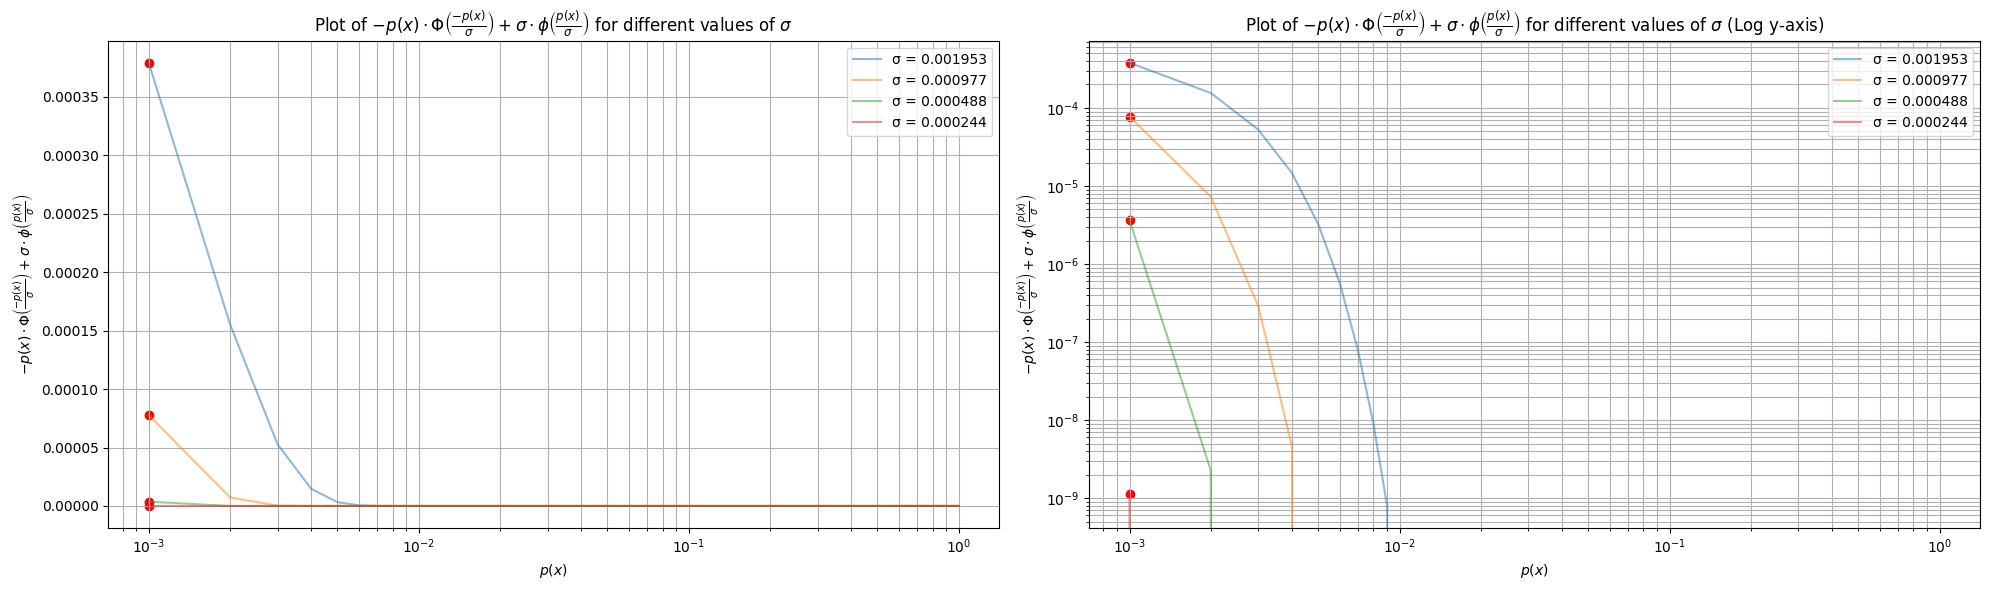

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the function with the normal CDF and PDF, with truncation of low values
def k_P_eps_less_than_k(p, sigma, threshold=1e-10):
    values = -p * norm.cdf(-p / sigma) + sigma * norm.pdf(-p / sigma)
    values[values < threshold] = 0
    return values

# Generate values of p(x) between 0 and 1
p_x_values = np.linspace(1e-3, 1, 1000)

# Updated smaller values of sigma
sigma_values = [1/512, 1/1024, 1/2048, 1/4096]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot settings
titles = [
    r'Plot of $-p(x) \cdot \Phi\left(\frac{-p(x)}{\sigma}\right) + \sigma \cdot \phi\left(\frac{p(x)}{\sigma}\right)$ for different values of $\sigma$',
    r'Plot of $-p(x) \cdot \Phi\left(\frac{-p(x)}{\sigma}\right) + \sigma \cdot \phi\left(\frac{p(x)}{\sigma}\right)$ for different values of $\sigma$ (Log y-axis)'
]
y_scales = ['linear', 'log']

for ax, title, y_scale in zip(axes, titles, y_scales):
    for sigma in sigma_values:
        function_values = k_P_eps_less_than_k(p_x_values, sigma)
        ax.plot(p_x_values, function_values, label=f'σ = {sigma:.6f}', alpha=0.5)
        max_index = np.argmax(function_values)
        max_k = p_x_values[max_index]
        max_value = function_values[max_index]
        ax.scatter(max_k, max_value, marker='o', color='red')  # Mark the maximum point
    ax.set_title(title)
    ax.set_xlabel(r'$p(x)$')
    ax.set_ylabel(r'$-p(x) \cdot \Phi\left(\frac{-p(x)}{\sigma}\right) + \sigma \cdot \phi\left(\frac{p(x)}{\sigma}\right)$')
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale(y_scale)
    ax.grid(True, which='both')

plt.tight_layout()
plt.show()


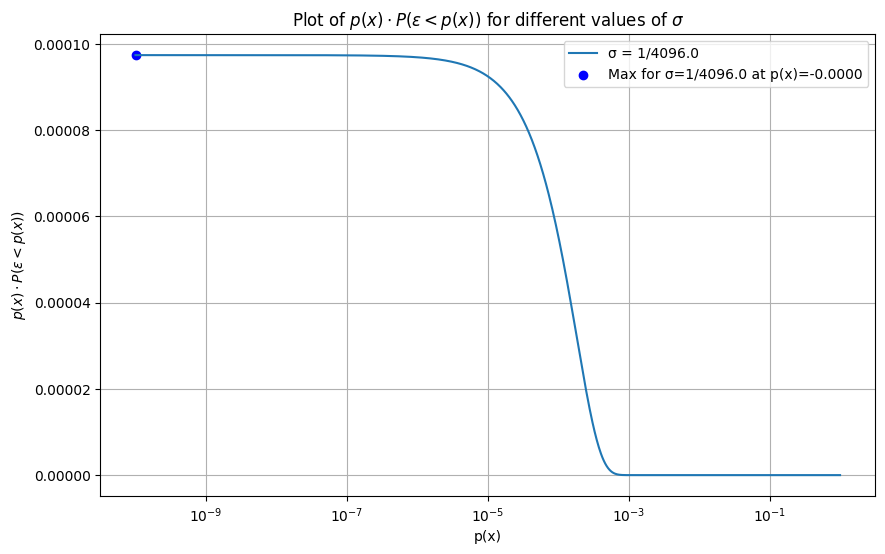

{0.000244140625: (1e-10, 9.73979676761392e-05)}

In [57]:
# Plot the function for different values of σ to visually inspect for minimum points in the original scale
plt.figure(figsize=(10, 6))
min_points_original = {}
p_x_values = np.logspace(-10, 0, 1000)

#sigma_values = [1/1024]
#sigma_values = np.logspace(-30, -5, num=26, base=2)
# sigma_values = [1/512, 1/1024, 1/2048, 1/4096]
sigma_values = [2**-12]

for sigma in sigma_values:
    function_values = k_P_eps_less_than_k(p_x_values, sigma)
    plt.plot(p_x_values, function_values, label=f'σ = 1/{1/sigma}')
    
    # Find the index where the function value is minimum
    min_idx = np.argmax(function_values)
    min_k = p_x_values[min_idx]
    min_value = function_values[min_idx]
    min_points_original[sigma] = (min_k, min_value)
    
    plt.scatter(min_k, min_value, marker='o', color='blue', label=f'Max for σ=1/{1/sigma} at p(x)={-min_k:.4f}')

plt.title(r'Plot of $p(x) \cdot P(\epsilon < p(x))$ for different values of $\sigma$')
plt.xlabel('p(x)')
plt.ylabel(r'$p(x) \cdot P(\epsilon < p(x))$')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

min_points_original


In [58]:
min_value

9.73979676761392e-05

In [17]:
function_values.argmin()

1

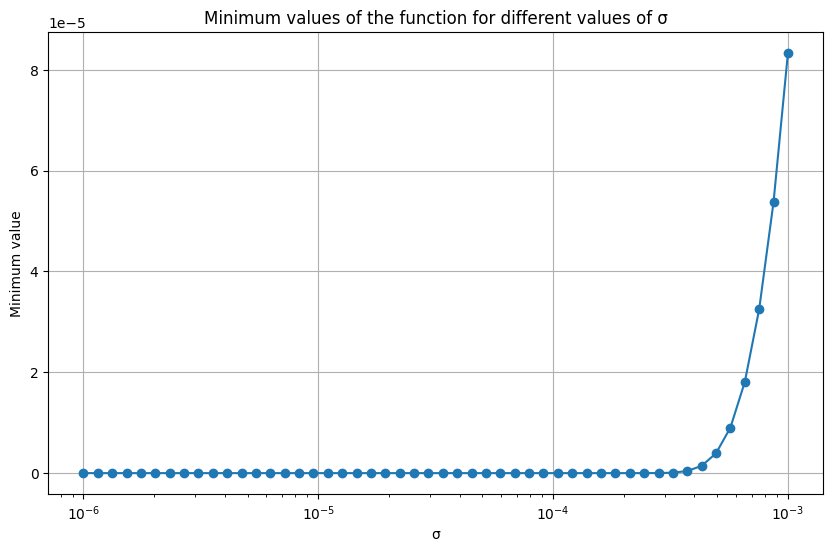

In [34]:
sigma_values = np.logspace(-6, -3, 50)
for sigma in sigma_values:
    function_values = k_P_eps_less_than_k(p_x_values, sigma)
    min_idx = np.argmax(function_values)
    min_k = p_x_values[min_idx]
    min_value = function_values[min_idx]
    min_points_original[sigma] = (min_k, min_value)

min_vals = [min_points_original[sigma][1] for sigma in sigma_values]

plt.figure(figsize=(10, 6))
plt.plot(sigma_values, min_vals, marker='o')
plt.title('Minimum values of the function for different values of σ')
plt.xlabel('σ')
#plt.yscale('log')
plt.xscale('log')
plt.ylabel('Minimum value')
plt.grid(True)
plt.show()


## Drawing the plot for calculation of $E[A^2]$

In [19]:
image1_epsilon_minus = np.where(image1.image_noised < 0, image1.image_noised, 0)
image2_epsilon_minus = np.where(image2.image_noised < 0, image2.image_noised, 0)
image1_noise = image1.image_noised - image1.image
image2_noise = image2.image_noised - image2.image

In [37]:
joint_image = image1_noise + image1_epsilon_minus + image2_epsilon_minus

In [42]:
A = np.sum(joint_image)

In [21]:
noise_values.shape

(100,)

In [22]:
average_A_values = []
average_A2_values = []

for noise in tqdm(noise_values):
    noise_A_values = []
    noise_A2_values = []
    for pair in list(itertools.combinations(image_numbers, 2)):
        A_values = np.zeros(num_exp)
        A2_values = np.zeros(num_exp)
        image1 = Image(resolution, category_names[0], pair[0], full_path)
        image2 = Image(resolution, category_names[0], pair[1], full_path)

        for i in range(num_exp):
            results = Image.process_images(image1, image2, noise)
            image1_epsilon_minus = -np.where(image1.image_noised < 0, image1.image_noised, 0)
            image2_epsilon_minus = -np.where(image2.image_noised < 0, image2.image_noised, 0)
            image1_noise = image1.image_noised - image1.image
            image2_noise = image2.image_noised - image2.image
            
            joint_image = image1_noise + image1_epsilon_minus + image2_epsilon_minus
            A = np.sum(joint_image)
            A_values[i] = A
            A2_values[i] = A ** 2

        # Calculate the average A for this pair and noise level
        average_A = np.mean(A_values)
        average_A2 = np.mean(A2_values)
        noise_A_values.append(average_A)
        noise_A2_values.append(average_A2)

    # Store the average A for all pairs for this noise level
    average_A_values.append(noise_A_values)
    average_A2_values.append(noise_A2_values)

# Convert to a numpy array for easy manipulation if needed
average_A_values = np.array(average_A_values)
average_A2_values = np.array(average_A2_values)


100%|██████████| 100/100 [03:48<00:00,  2.29s/it]


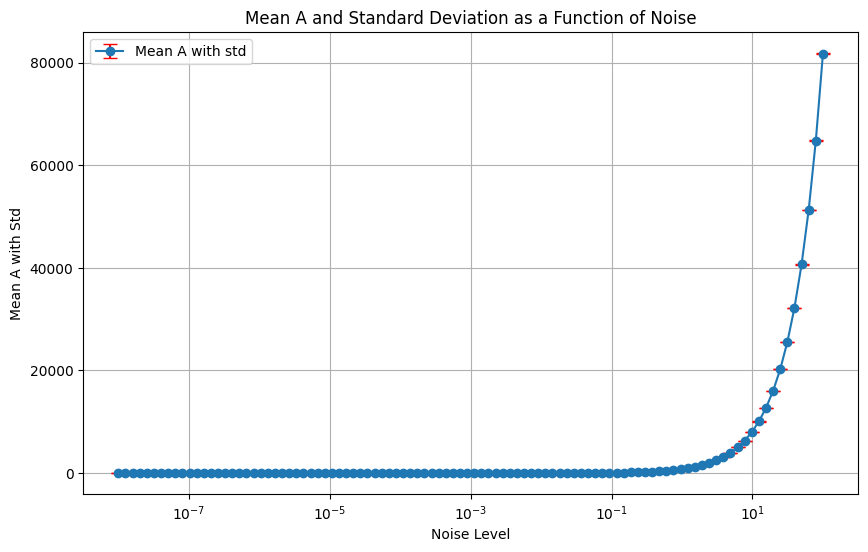

In [23]:
# Calculate mean and standard deviation for each noise level
mean_A_values = np.mean(average_A_values, axis=1)
std_A_values = np.std(average_A_values, axis=1)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.errorbar(noise_values, mean_A_values, yerr=std_A_values, fmt='-o', ecolor='r', capsize=5, label='Mean A with std')

plt.xlabel('Noise Level')
plt.ylabel('Mean A with Std')
plt.title('Mean A and Standard Deviation as a Function of Noise')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()


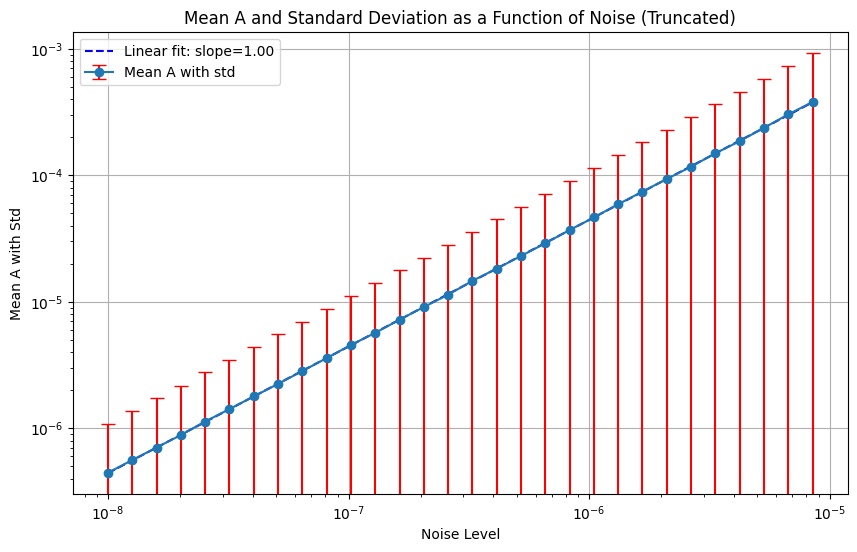

In [48]:
truncated_indices = [i for i, noise in enumerate(noise_values) if noise < 10**-5]
truncated_noise_values = [noise for noise in noise_values if noise < 10**-5]
truncated_mean_A_values = mean_A_values[truncated_indices]
truncated_std_A_values = std_A_values[truncated_indices]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.errorbar(truncated_noise_values, truncated_mean_A_values, yerr=truncated_std_A_values, fmt='-o', ecolor='r', capsize=5, label='Mean A with std')

# Log-log plot for the linear approximation
log_noise = np.log10(truncated_noise_values)
log_mean_A = np.log10(truncated_mean_A_values)

# Fit a linear model to the log-log data
slope, intercept = np.polyfit(log_noise, log_mean_A, 1)
linear_fit = 10**(slope * log_noise + intercept)

# Plot the linear fit
plt.plot(truncated_noise_values, linear_fit, 'b--', label=f'Linear fit: slope={slope:.2f}')

plt.xlabel('Noise Level')
plt.ylabel('Mean A with Std')
plt.title('Mean A and Standard Deviation as a Function of Noise (Truncated)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

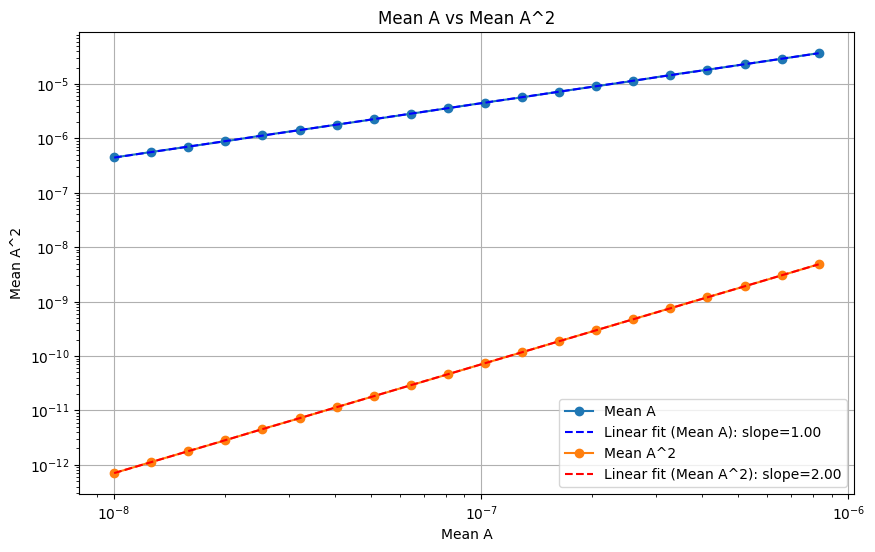

In [50]:
truncated_indices = [i for i, noise in enumerate(noise_values) if noise < 10**-5]
truncated_noise_values = [noise for noise in noise_values if noise < 10**-5]
truncated_mean_A_values = mean_A_values[truncated_indices]
truncated_std_A_values = std_A_values[truncated_indices]

# Calculate A^2 values
mean_A2_values = np.mean(average_A2_values, axis=1)
std_A2_values = np.std(average_A2_values, axis=1)
truncated_mean_A2_values = mean_A2_values[truncated_indices]
truncated_std_A2_values = std_A2_values[truncated_indices]

# Plotting the results: Mean A vs Mean A^2
plt.figure(figsize=(10, 6))
plt.plot(truncated_noise_values, truncated_mean_A_values, 'o-', label='Mean A')
# Add a linear fit to the plot
slope_A, intercept_A = np.polyfit(np.log10(truncated_noise_values), np.log10(truncated_mean_A_values), 1)
linear_fit_A = 10**(slope_A * np.log10(truncated_noise_values) + intercept_A)
plt.plot(truncated_noise_values, linear_fit_A, 'b--', label=f'Linear fit (Mean A): slope={slope_A:.2f}')

plt.plot(truncated_noise_values, truncated_mean_A2_values, 'o-', label='Mean A^2')
# Add a linear fit to the plot
slope_A2, intercept_A2 = np.polyfit(np.log10(truncated_noise_values), np.log10(truncated_mean_A2_values), 1)
linear_fit_A2 = 10**(slope_A2 * np.log10(truncated_noise_values) + intercept_A2)
plt.plot(truncated_noise_values, linear_fit_A2, 'r--', label=f'Linear fit (Mean A^2): slope={slope_A2:.2f}')

plt.xlabel('Mean A')
plt.ylabel('Mean A^2')
plt.title('Mean A vs Mean A^2')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# Calculate the slope of the linear fit for the mean A and mean A^2
print(f'Slope for Mean A: {slope_A:.4f}')
print(f'Slope for Mean A^2: {slope_A2:.4f}')
print(f'Intercept for Mean A: {10  ** intercept_A:.4f}')
print(f'Intercept for Mean A^2: {10 ** intercept_A2:.4f}')
print(f'Approximation of what A intercept needs to be {np.sqrt(2) * resolution}')
print(f'Approximation of what A^2 intercept needs to be {2 * resolution ** 2}')

Slope for Mean A: 0.9991
Slope for Mean A^2: 1.9993
Intercept for Mean A: 43.6274
Intercept for Mean A^2: 6965.1026
Approximation of what A intercept needs to be 45.254833995939045
Approximation of what A^2 intercept needs to be 2048


In [27]:
intercept_A2

3.848754301235024

In [28]:
np.log10(7021.2789)

3.8464162244696993